# Apache Spark Tutorial

Joeri Hermans (joeri.hermans@doct.ulg.ac.be)                           
University of Liège                                             

This notebook will guide the students of "Large-Scale Distributed Systems" through their initial steps with [Apache Spark](https://spark.apache.org). If you would like additional information about the concepts presented in this notebook, please refer to the [Spark Programming Guide](https://spark.apache.org/docs/latest/rdd-programming-guide.html). I would like to note that most solutions you will find on StackOverflow are not always optimal, or are even outdated. So please think carefully before applying a StackOverflow solution.

## Downloading, unpacking, installing and system configuration

In [ ]:
# Download the latest version of Apache Spark.
!rm -r spark-2.2.0-bin-hadoop2.7.tgz
!wget -q http://apache.tt.co.kr/spark/spark-2.2.0/spark-2.2.0-bin-hadoop2.7.tgz

In [ ]:
# Unpack the framework.
!rm -r apache-spark
!tar -xzf spark-2.2.0-bin-hadoop2.7.tgz
!mv spark-2.2.0-bin-hadoop2.7 apache-spark
!ls -al

In [ ]:
# Move it to the desired location. Make sure destination is writable.
!rm -rf /opt/apache-spark     # CHANGE DESTINATION PATH IF DESIRED.
!mv apache-spark /opt/        # CHANGE DESTINATION PATH IF DESIRED.

In [1]:
# Now, in order to use the libraries, make sure the libs are included in $PATH and $PYTHONPATH.
# Add this to your .bashrc or .zshrc depending on your shell.
!export SPARK_HOME=/opt/apache-spark   # CHANGE DESTINATION PATH IF DESIRED.
!export PYTHONPATH="$SPARK_HOME/python/:$SPARK_HOME/python/lib/py4j-0.10.4-src.zip:$PYTHONPATH"
!export PATH="$SPARK_HOME/bin:$PATH"

# Usually this is done at a cluster level, so you should not have to worry about it.
!export JAVA_OPTS="-Xms512m -Xmx2048m"

## Apache Spark

Test your installation by importing the Python module. If you did everything correctly, this should not produce any errors.

In [2]:
import pyspark

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession

In the following sections we give a basic introduction to most of the concepts in Spark, and how (not) to use them. If you whish to implement something specific, you can always refer to the [documentation](https://spark.apache.org/docs/latest/quick-start.html).

As you saw in the lecture, Apache Spark provides two distinct concepts where computation resides. The first being the *driver*, which is basically the process which is responsible for issuing the tasks to the cluster, it is also used for *collecting* the results of the computation. The second, and final being the *executors*, which actually *execute* the tasks issues by the driver. Furthermore, an executor is also responsible for maintaining the state of the computation. For instance, if you issue a set of tasks from the driver process, and go for a coffee for instance, the (intermediate) result of the computation cannot be lost as long as the driver process is still alive.

Depending on how the cluster is configured (stand-alone, YARN, Mesos, ...), a different master-address has to be specified. The master will basically allocate the resources you requested and assign them to the requestor. In general, you have to specify 4 things before starting your Spark Application, i.e., the `application_name`, the `master_address` or master-mode (e.g., yarn-client, in this case you request yarn to schedule your resources), `num_executors` which obviously defines the number of executors you whish to use, and finally, `num_processes` which is the number of child-processes (you can view them as threads) which are run in a single executor. This option is advantegeous in the sense that the child processes within a single executor will share the same memory. As a result, these processes can share data really quickly (instead of reading data from a different node on the network).

In [3]:
# Define the name of your application.
application_name = "Large-Scale Distributed Systems: Spark Tutorial"

# Define the master address, for local mode this is local[*].
# If you don't want to use all cores on your machine please specify local[n].
master = "local[*]"
# Number of executors.
num_executors = 2
# Number of child processes per executors.
num_processes = 2

Now, using these options, we are able to construct a `SparkConf` object which tells the cluster how to allocate the resources, and specify the behaviour of the cluster. In the configuration specified below, you use the variables which are defines above, including the amount of memory you require on an executor level. In general, Spark thrives on the availability of RAM (more data can be kept in memory, so it can be processed faster).

A different option you can specify is a custom `Serializer`, the sole responsibility of the serializer is to serialize the memory to some kind of persistent medium whenever it doesn't fit in memory. Nevertheless, the way in-memory (heap) objects are serialized can differ from implementation. By default, Spark will use the Java serializer, which in some cases might not be sufficient because it fails to encode dependencies. That's why it is commonly a good-practice to use the Kryo Serializer. Furthermore, it is also faster than the Java serializer.

In [4]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", str(num_processes))
conf.set("spark.executor.instances", str(num_executors))
conf.set("spark.executor.memory", "2g")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")

In general, the list of options you can specify are basically endless, and are application-dependent in order to obtain a good throughput of your processing application. If you would to look op a specific options, like e.g., increasing the *heartbeat* timeout, you could look it up in the [configuration documentation](https://spark.apache.org/docs/latest/configuration.html).

An other interesting concept in the Hadoop / Spark environment is the concept of *data locality*. Data locality, in principle, is a pretty powerfull concept in any distributed ecosystem which employs it, since it is an indirect side-effect of data replication on the distributed file system (in this case, HDFS), and of the processing which happens on top of that data. For instance, if you would schedule a certain set of tasks on the cluster, it would be rather inefficient to read a copy of the data on the disk of a remote machine, while a copy of the same data persists on a local disk. This concept can be extended even further on multiple levels, from the [Spark Tuning Guide](https://spark.apache.org/docs/latest/tuning.html#data-locality) (complete guide is recommended for optimizing your tasks):

- **```PROCESS_LOCAL```** data is in the same JVM as the running code. This is the best locality possible
- **```NODE_LOCAL```** data is on the same node. Examples might be in HDFS on the same node, or in another executor on the same node. This is a little slower than PROCESS_LOCAL because the data has to travel between processes
- **```NO_PREF```** data is accessed equally quickly from anywhere and has no locality preference
- **```RACK_LOCAL```** data is on the same rack of servers. Data is on a different server on the same rack so needs to be sent over the network, typically through a single switch
- **```ANY```** data is elsewhere on the network and not in the same rack

Of course, evaluating wheter data resides on the machine of the task, or on a machine on a different level (RACK_LOCAL or ANY) requires evaluating the current task graph, because maybe an executor is already processing this particular data and has it in memory, and if it does not reside there, it has to contact the HDFS journal to check where the copies of the data reside to actually pick to most efficient transfer. However, in some applications, (e.g., training neural networks concurrently), it is important that *mini-batches* arrive ASAP (as-fast-as-possible). As a result, checking for the most efficient data transfer might not be desirable. To solve this particular issue, Spark also provides an `spark.locality.wait` option where you can specify the amount of time you need to wait before Spark *launches a data-local task before giving up and launching it on a less-local node*.

In [5]:
# Since this notebook is (proably) run locally, locality 0 is desired.
conf.set("spark.locality.wait", "0")

The first thing a Spark program must do is to create a SparkSession object (which contains a SparkContext), which tells Spark how to access a cluster. To create a SparkSession we need to use the SparkConf object we previously created since it contains information about the application we want to run on the cluster.

In [6]:
# Allocate a Spark session based on the provided configuration and application name.
# Which may, or may not, already be created (getOrCreate()).
spark = SparkSession.builder.config(conf=conf).appName(application_name).getOrCreate()
# Create a shortcut for the SparkContext.
sc = spark.sparkContext

The main abstraction Spark provides is a resilient distributed dataset (RDD), which is a collection of elements partitioned across the nodes of the cluster that can be operated on in parallel. RDDs are created by starting with a file in the Hadoop file system (or any other Hadoop-supported file system), or an existing list in the driver program, and transforming it. Users may also ask Spark to persist an RDD in memory, allowing it to be reused efficiently across parallel operations. Finally, RDDs automatically recover from node failures.

## BetterPiSpark

Traditionally, starting users run the `PiSpark` example which basically  estimates Pi using the sampling method. However, the way the example is implemented is actually a non-efficient method since it relies on a list of indexes which scales lineary with the input. Meaning, for every item in the list the method will compute one sample. This is not a very efficient way to do this, you can imagine if you are processing images that you will not be able to load TBs of image data in the RAM of your driver program, and then parallelize to the cluster. As a result, we will construct a `BetterPiSpark` example, which I will guide you through.

Given our resource allocation defined in the `SparkConf` object, we know the total number of concurrent processes or tasks that will be running whenever we submit some jobs in the cluster. This is basically `num_executors` $*$ `num_processes`.

In [7]:
num_parallel_processes = num_executors * num_processes

A way to generate the samples more efficiently, would be to tell every concurrent task to generate a specific number number of random samples. To do this, we first need to construct an RDD which holds the number of samples that every task has to generate.

In [8]:
# Define the total number of samples that has to be generated.
total_samples = 10000000
# Define the number of samples per process.
samples_per_process = int(total_samples / num_parallel_processes)
samples = [samples_per_process] * num_parallel_processes

Now we have a list in the driver program which specifies the number of samples per process, we have to parallelize that list over the cluster.

In [9]:
sample_sizes_rdd = sc.parallelize(samples)

In order to ensure that the RDD really holds 4 items, we can call a simple `count` operation. However, note that compared to `len(samples)` this operation is quite slow (for this amount of data) because the tasks have to be scheduled among all executors and processes, and collected afterwards.

**Interesting observation:** Running this cell twice will (probably) be faster than the initial try, why?

In [10]:
sample_sizes_rdd.count() == len(samples)

True

In order to ensure that the data is distributed equally among all machines on has in princple two options. The first being a **repartition** which obviously repartitions the data according to the specified integer. However, there are several *pitfalls* when applying this method. The first being that this method should only be applied whenever the new number of partitions is larger than the current number of partitions, i.e., `rdd.repartition(new_num_partitions).getNumPartitions() > rdd.getNumPartitions()`. The second being that the number of new partitions you actually specify is equivalent to the number of tasks that will be executed whenever you call an *action*. Meaning, if you have allocated 4 executors on 4 different machines, and every executor has 2 threads, and you repartition the RDD to the number of machines (4), there will be 4 unused cores. Therefore, as recommended in the Spark documentation, it is a good practice to set the number of partitions equal to ~2/3 times the number of processes, i.e., `3 * num_processes`. Nevertheless, in some situations it might actually be desired that all data in a single partition is processed by a single executor on a single machine, but this depends on your use-case.

The second method is a **coalesce**. In general, you should only use this method whenever you want to repartition your data to a smaller number of partitions then you *currently* have, i.e., `rdd.repartition(new_num_partitions).getNumPartitions() < rdd.getNumPartitions()`. The reason for this distinct approach is because this approach efficient in this situation since it imposes the constraint that only a specific subset of the data will have to be moved instead of scattered among the cluster machines.

In [11]:
print("Number of partitions before repartitioning: " + str(sample_sizes_rdd.getNumPartitions()))

# Ensure that the rdd is equally distributed among all concurrent processes.
sample_sizes_rdd = sample_sizes_rdd.repartition(num_parallel_processes)

print("Number of partitions after repartitioning: " + str(sample_sizes_rdd.getNumPartitions()))

Number of partitions before repartitioning: 4
Number of partitions after repartitioning: 4


From the number of samples per partition, we now want to generate, for every partition, the specified number of random samples. This can by done by constructing a lambda generator which yields the specified number of coordinate. Please note that there is a distinct difference between **map** and **mapPartitions**, and apply where needed. In general, *map* should always be applied whenever there is an element to element mapping. However, the use-cases for *mapPartitions* have several extensions. The first being if there is no element to element mapping, you could for example generate many instances based on a single element, or even filter. *mapPartitions* is also usefull in the case you want to log some data to a database for instance. In principle, you could achieve the same with *map*, but with the difference that you have to set-up a database connection for every element you map. This is *inefficient*, so don't do this. On the other hand, *mapPartitions* would be a perfect fit, because you would be able to parallelize the insertion into a database (among the partitions), and maintain a database handle for multiple samples.

This is exactly the reasoning for applying the lambdas shown below. Given a number of samples for every partition (for which we know there is 1), we yield num_smaples random points. Then, since we have an element-to-element mapping, we apply the in_circle lambda method to generate an RDD of 1's and 0's based on the coordinate of an element.

In [12]:
from random import random

def generate_points(iterator):
    for num_samples in iterator:
        for i in range(0, num_samples):
            x = random() * 2 - 1
            y = random() * 2 - 1
            yield [x, y]
            
def in_circle(tuple):
    x = tuple[0]
    y = tuple[1]
    
    return int((x ** 2 + y ** 2) <= 1)

# Apply the specified lambda function for every partition.
points_rdd = sample_sizes_rdd.mapPartitions(generate_points)
# Compute whether the samples points are within the circle.
pi_rdd = points_rdd.map(in_circle)

Finally, to obtain the number of random points which were within the unit-circle. We simply invoke a *reduce* **action** with the *add* operator (to sum all elements). Not that in Spark, an **action** will always invoke a computation of the DAG, while operations as *map* and *mapPartitions* do not.

**Note**: In principle you could implement the reduce implementation yourself using the methods described above.

In [13]:
from operator import add

# Compute the number of points within the circle.
within_circle = pi_rdd.reduce(add)

print("Number of points in circle: " + str(within_circle))

Number of points in circle: 7853528


This result allows us to approximate Pi using the sampling as shown below.

In [14]:
import numpy as np

# Compute the approximated value of Pi.
pi = (4. * within_circle / total_samples)

print("Pi is approximatly " + str(pi))
print("True value of Pi: " + str(np.pi))
print("Error: " + str(np.abs(np.pi - pi)))

Pi is approximatly 3.1414112
True value of Pi: 3.141592653589793
Error: 0.000181453589793


To plot the data, it would be kind of crazy to *collect* all data distributed across the cluster onto a single machine, so in order to make some convincing plot it is usually a good practice to sample some data from the complete RDD. In our case, we would like to identify the points which were sampled inside the unit circle with a different color. So what we want, is a "label" for every point we have sampled. To make our life a little bit easier, we can use a **DataFrame** abstraction which imposes a table schema upon an RDD.

Building this RDD is very trivial, we just convert the points RDD (which we already computed and cached) into a dictionary and attach the computed label. This way, Spark can automatically infer the schema of the table, and the associated types.

In [15]:
from pyspark.sql import Row

def construct_point_labels(row):
    d = {}
    # Input is a list / tuple.
    x = row[0]
    y = row[1]
    # Assign the point tuple to the point column.
    d['point'] = row
    # Compute the label, and assign it to the label column.
    d['in_circle'] = in_circle(row)
    
    # Unrolling the dictionary, i.e., key_1=value_1, key_2=value_2, ...
    return Row(**d)

# Generate new random points.
points_rdd = sample_sizes_rdd.mapPartitions(generate_points)
points_rdd.cache() # Cache the data in memory.

print("Number of points: " + str(points_rdd.count()))

# Map the points RDD to the desired scheme.
# The .toDF call will tell Spark to derrive the schema and provide DataFrame functionality.
table = points_rdd.map(construct_point_labels).toDF()
table.cache()

# View the schema of the table.
table.printSchema()

Number of points: 10000000
root
 |-- in_circle: long (nullable = true)
 |-- point: array (nullable = true)
 |    |-- element: double (containsNull = true)



Now, to make our plots we can simple extract the points which were inside the circle purely based upon the label. Again, for plotting and efficiency purposes, we choose to sample a small subset of the total data.

In [16]:
# Sample the outer-circle points.
out_circle = table.filter(table.in_circle == 0).select("point").sample(False, .01).collect()
# Sample the inner-circle points.
in_circle = table.filter(table.in_circle == 1).select("point").sample(False, .01).collect()

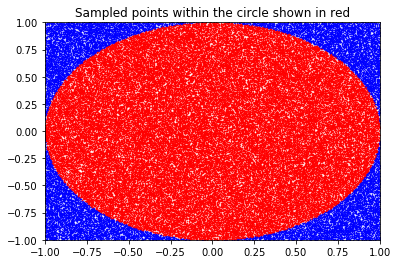

In [17]:
import matplotlib.pyplot as plt

# Plot the points outside the circle.
x = [e['point'][0] for e in out_circle]
y = [e['point'][1] for e in out_circle]
plt.scatter(x, y, s=.2, c='blue')
# Plot the points inside the circle.
x = [e['point'][0] for e in in_circle]
y = [e['point'][1] for e in in_circle]
plt.scatter(x, y, s=.2, c='red')
# Other plotting options.
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title("Sampled points within the circle shown in red")

# Show the plot.
plt.show()

## PageRank

**Note**: A more efficient version of PageRank exists in Spark GraphX. Use that one.

In this particular example we will find the most popular article on Wikipedia using the PageRank algorithm. For that, we need to construct a graph containing all links in all Wikipedia articles. Luckily for us, there exists a project which maintiains this ([link](http://snap.stanford.edu/data/wikispeedia.html)).

In [19]:
!wget http://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz
!tar xzf wikispeedia_paths-and-graph.tar.gz
!cp wikispeedia_paths-and-graph/links.tsv .
!rm -r wikispeedia_paths-and-graph && rm wikispeedia_paths-and-graph.tar.gz
!ls -al

--2017-11-21 06:16:30--  http://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz
Resolving snap.stanford.edu... 171.64.75.80
Connecting to snap.stanford.edu|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9901821 (9.4M) [application/x-gzip]
Saving to: ‘wikispeedia_paths-and-graph.tar.gz’

wikispeedia_paths-a 100%[===================>]   9.44M  1.12MB/s    in 8.9s    

2017-11-21 06:16:40 (1.06 MB/s) - ‘wikispeedia_paths-and-graph.tar.gz’ saved [9901821/9901821]

total 3216
drwxr-xr-x  4 joeri joeri    4096 Nov 21 06:16 .
drwxr-xr-x 10 joeri joeri    4096 Nov 21 06:04 ..
drwxr-xr-x  2 joeri joeri    4096 Nov 16 08:38 .ipynb_checkpoints
-rw-r--r--  1 joeri joeri 3107133 Nov 21 06:16 links.tsv
-rw-r--r--  1 joeri joeri  164693 Nov 21 06:15 spark-tutorial.ipynb
drwxr-xr-x  2 joeri joeri    4096 Nov 16 01:30 spark-warehouse


In [44]:
# Loads in input file. It should be in format of:
#     URL URL
#     URL URL
#     URL URL
#     ...
def is_comment(line):
    """Filters the line if the line is a comment."""
    if len(line) > 0 and line[0] is not '#':
        return line

lines = spark.read.text("links.tsv").rdd.map(lambda r: r[0]).filter(is_comment)

print("Number of links: " + str(lines.count()))

Number of links: 119882


In [54]:
import re

def parseNeighbors(urls):
    """Parses a urls pair string into urls pair."""
    parts = urls.split("\t")
    return parts[0], parts[1]

# Loads all URLs from input file and initialize their neighbors.
links = lines.map(lambda urls: parseNeighbors(urls)).distinct().groupByKey().cache()

In [55]:
# Loads all URLs with other URL(s) link to from input file and initialize ranks of them to one.
ranks = links.map(lambda url_neighbors: (url_neighbors[0], 1.0))

In [57]:
def computeContribs(urls, rank):
    """Calculates URL contributions to the rank of other URLs."""
    num_urls = len(urls)
    for url in urls:
        yield (url, rank / num_urls)

# Define the number of iterations.
num_iterations = 10
# Iteratively update the URL using the PageRank algorithm.
for iteration in range(0, num_iterations):
    # Calculates URL contributions to the rank of other URLs.
    contribs = links.join(ranks).flatMap(lambda url_urls_rank: computeContribs(url_urls_rank[1][0], url_urls_rank[1][1]))
    # Re-calculates URL ranks based on neighbor contributions.
    ranks = contribs.reduceByKey(add).mapValues(lambda rank: rank * 0.85 + 0.15)

In [58]:
# Collects all URL ranks and dump them to stdout.
for (link, rank) in ranks.collect():
    print("%s has rank: %s." % (link, rank))

United_States has rank: 39.59571127985303.
World_War_II has rank: 19.830185438297132.
Australia has rank: 13.44125570263114.
New_Zealand has rank: 7.160964238864231.
United_Kingdom has rank: 26.227255494351304.
Pluto has rank: 0.6923891651304033.
Spain has rank: 15.428915639227151.
Film has rank: 3.53079790038677.
Rwanda has rank: 1.4007416756580868.
Ancient_Rome has rank: 6.686004586982277.
Bird has rank: 5.405146621751485.
Ethiopia has rank: 2.7347891866594987.
Sydney has rank: 1.6410035831282463.
Elementary_algebra has rank: 0.23168761731300447.
Hammurabi has rank: 0.5631516372576931.
Portugal has rank: 10.155912403883553.
American_Revolutionary_War has rank: 1.4640963984065285.
British_House_of_Commons has rank: 2.280321295950153.
Netherlands has rank: 9.713498094443764.
The_Bahamas has rank: 1.4616328554957705.
Plutonium has rank: 0.8770601062188258.
Alphabet has rank: 0.7050203555314103.
Byzantine_Empire has rank: 5.49956513922541.
Democracy has rank: 5.990961559672528.
Literatur

North_Korea has rank: 2.577927078377375.
Louis_XIV_of_France has rank: 1.3802406083459997.
William_III_of_England has rank: 1.1185723064382922.
Cell_%28biology%29 has rank: 2.873342002796217.
Calcium has rank: 2.45594712812401.
Zirconium has rank: 0.38005708155233126.
Arabic_language has rank: 7.852864946385761.
Benin has rank: 1.2673030789954771.
French_Southern_and_Antarctic_Lands has rank: 0.34864645709505293.
Guinea has rank: 1.6149013690860552.
Guinea-Bissau has rank: 1.2914996737153412.
Saint_Helena has rank: 1.0113470510249236.
Senegal has rank: 2.214599634636396.
Togo has rank: 1.3788298701599175.
Cereal has rank: 1.945192093789175.
Scramble_for_Africa has rank: 0.7558433465502663.
Southern_Africa has rank: 1.182008828385263.
U.S._state has rank: 2.325192811792024.
Physics has rank: 5.882811871792294.
Acts_of_Union_1707 has rank: 0.9499687061182579.
Antigua_and_Barbuda has rank: 0.9144378704245693.
Church_of_Ireland has rank: 1.0767998228258209.
Mary_I_of_England has rank: 0.75

Grand_Slam_%28tennis%29 has rank: 0.8550680699956247.
Vietnam has rank: 4.040854100865268.
Jackdaw has rank: 0.24419477374194534.
Ape has rank: 0.4462241687515148.
Monkey has rank: 0.5236793544157803.
Alexander_the_Great has rank: 2.404220482842758.
Blitzkrieg has rank: 0.8425883120319608.
Luftwaffe has rank: 1.202578366541918.
Soviet_Union has rank: 9.500736387669427.
Pea has rank: 1.2273599760855862.
Ancient_history has rank: 0.768649849709368.
Names_of_God_in_Judaism has rank: 0.5453121806556179.
Meteorology has rank: 1.9624956230573956.
Gull has rank: 0.4451195495998842.
Theropoda has rank: 0.4970747191599041.
BBC_television_drama has rank: 0.19939393750789933.
City_status_in_the_United_Kingdom has rank: 1.089227814663463.
Glasgow has rank: 1.8867692361882313.
Leicester has rank: 0.551921144664092.
Liberal_Democrats has rank: 0.8804945945487187.
Sulfuric_acid has rank: 1.5163602296657746.
Seaborgium has rank: 0.2414929666586768.
Lindisfarne_Gospels has rank: 0.20846263828023243.
Bl

Of course, printing the rank information to stdout or to this notebook is not of any practical significance. In order to use these results in a search-result, or in a later analysis. What is commonly done is that it is stored in a particular format. However, since we have a tabular structure it makes sense to store the data in a table format on a persistent medium. The obvious solution would be to store the data in a CSV-format or something. However, this is horribly data inefficient, especially when the data is not compressed.

The following [post](https://db-blog.web.cern.ch/blog/zbigniew-baranowski/2017-01-performance-comparison-different-file-formats-and-storage-engines) from the CERN Database Group provides a good insight into what kind of storage solutions should be used given a particular use-case. But in general the following is a good rule of thumb: when you have the scan the data fully, thus all columns, use *Avro* (row storage). If this is not the case, *Parquet* (columunar storage). Why? :) 

## Stopping the SparkSession

In [ ]:
# Finally, stop the Spark session to free up the allocated resources.
spark.stop()